In [1]:
import torch 
import torch.utils.data
import torch.nn as nn
from torch.autograd import Variable

from dataset.readVideo import DramaDataset
from utils.tokenMaker import Lang
from utils.tool import padding
import pickle
import os
import matplotlib.pyplot as plt
from Similarity.model import GesdSimilarity
useCuda = True
device = torch.device("cuda" if useCuda else "cpu")

In [2]:
DataDir="/home/ball/Videos/BrokeEN"
datasets = DramaDataset(basedir=DataDir,
                        maxFrame=0,
                        )
import random
def getSample(size):
    imgs = []
    pres = []
    nexs = []
    for i in range(size):
        pre, nex, img = random.choice(datasets)
        imgs.append(img)
        pres.append(pre)
        nexs.append(nex)
    return pres, nexs, imgs

Total Drama: 113


In [3]:
ModelDir = "Similarity/models/second"
with open(os.path.join(ModelDir, "Lang.pkl"), 'rb') as f:
    lang = pickle.load(f)
    print("Load lang model: {}. Word size: {}".format(ModelDir, len(lang)))
model = torch.load(os.path.join(ModelDir, "SimilarityModel.39.pth")).to(device).eval()

Load lang model: Similarity/models/second. Word size: 15479


/home/ball/anaconda3/lib/python3.5/site-packages/torch/serialization.py:367: SourceChangeWarning: source code of class 'model.model.EncoderRNN' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


In [4]:
vectorTransforms = [lambda x: torch.LongTensor(x).to(device)]
def sentenceToVector(sentences, lang, sos=False, eos=False):
    vectors = []
    for s in sentences:
        vectors.append(lang.sentenceToVector(s, sos=sos, eos=eos))
    vectors = padding(vectors, lang["PAD"], vectorTransforms)
    return vectors

In [5]:
def makeNegSample(pres, nexs, negSize):
    mpres = []
    mnexts = []
    scores = []
    for pre, nex in zip(pres, nexs):
        while True:
            negs = random.sample(nexs, negSize)
            if not nex in negs:
                break
        mpres +=[pre] * (negSize + 1)
        mnexts += [nex] + negs
        scores += [1] + [0] * negSize
    return mpres, mnexts, scores

In [6]:
pres, nexs, imgs = getSample(32)

In [7]:
p,n,s = makeNegSample(pres, nexs, negSize=3)
vpres = sentenceToVector(p, lang)
vnexts = sentenceToVector(n, lang)
scores = torch.Tensor(s).to(device)

In [10]:
outputs = model(vpres, vnexts)
(outputs.round() == scores).float().mean()

tensor(1., device='cuda:0')

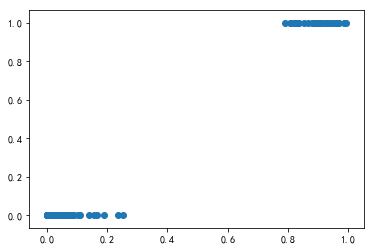

In [11]:
import matplotlib.pyplot as plt
plt.scatter(outputs.cpu().detach().numpy(), scores.cpu().detach().numpy())
plt.show()

In [6]:
import pandas as pd
result = pd.read_json("result.json")

In [7]:
vpres = sentenceToVector(result["pre"], lang)
vnexts = sentenceToVector(result["make"], lang)

In [8]:
outputs = model(vpres, vnexts)

In [9]:
dsOutput = pd.Series(outputs.detach())

count    144.000000
mean       0.089604
std        0.144128
min        0.000145
25%        0.031183
50%        0.055557
75%        0.089111
max        0.966471
dtype: float64


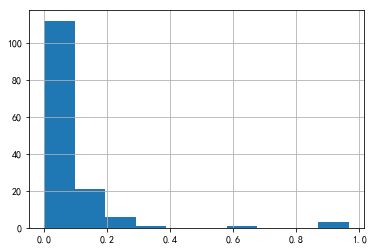

In [10]:
dsOutput.hist()
print(dsOutput.describe())
plt.show()